In [50]:
import numpy as np
import pickle
from matplotlib import pyplot as plt

In [51]:
with open('Results/final_output.pkl', 'rb') as f:
    results = pickle.load(f)

In [52]:
X_ori = results['x'].cpu().detach().numpy()
z = results['z'].cpu().detach().numpy()
sindy_coeff = results['sindy_coefficients'].cpu().detach().numpy()
Theta = results['Theta'].cpu().detach().numpy()

In [53]:
# Measured_Index (change this based on cases)
measured_index = [0,3,6,9,12,15]
X_ori = X_ori[:, measured_index]

In [54]:
# not measured station (change this based on cases)
no_measure_index = [3]
X_noMeasure = np.load('Data/X_red.npy')[:,no_measure_index].reshape(-1,1)
train_obs = round(X_noMeasure.shape[0]*0.8)
X_noMeasure = X_noMeasure[train_obs:,:]/100

In [55]:
#Combine measured station with not measured station
X_ori = np.concatenate((X_ori, X_noMeasure), axis=1)

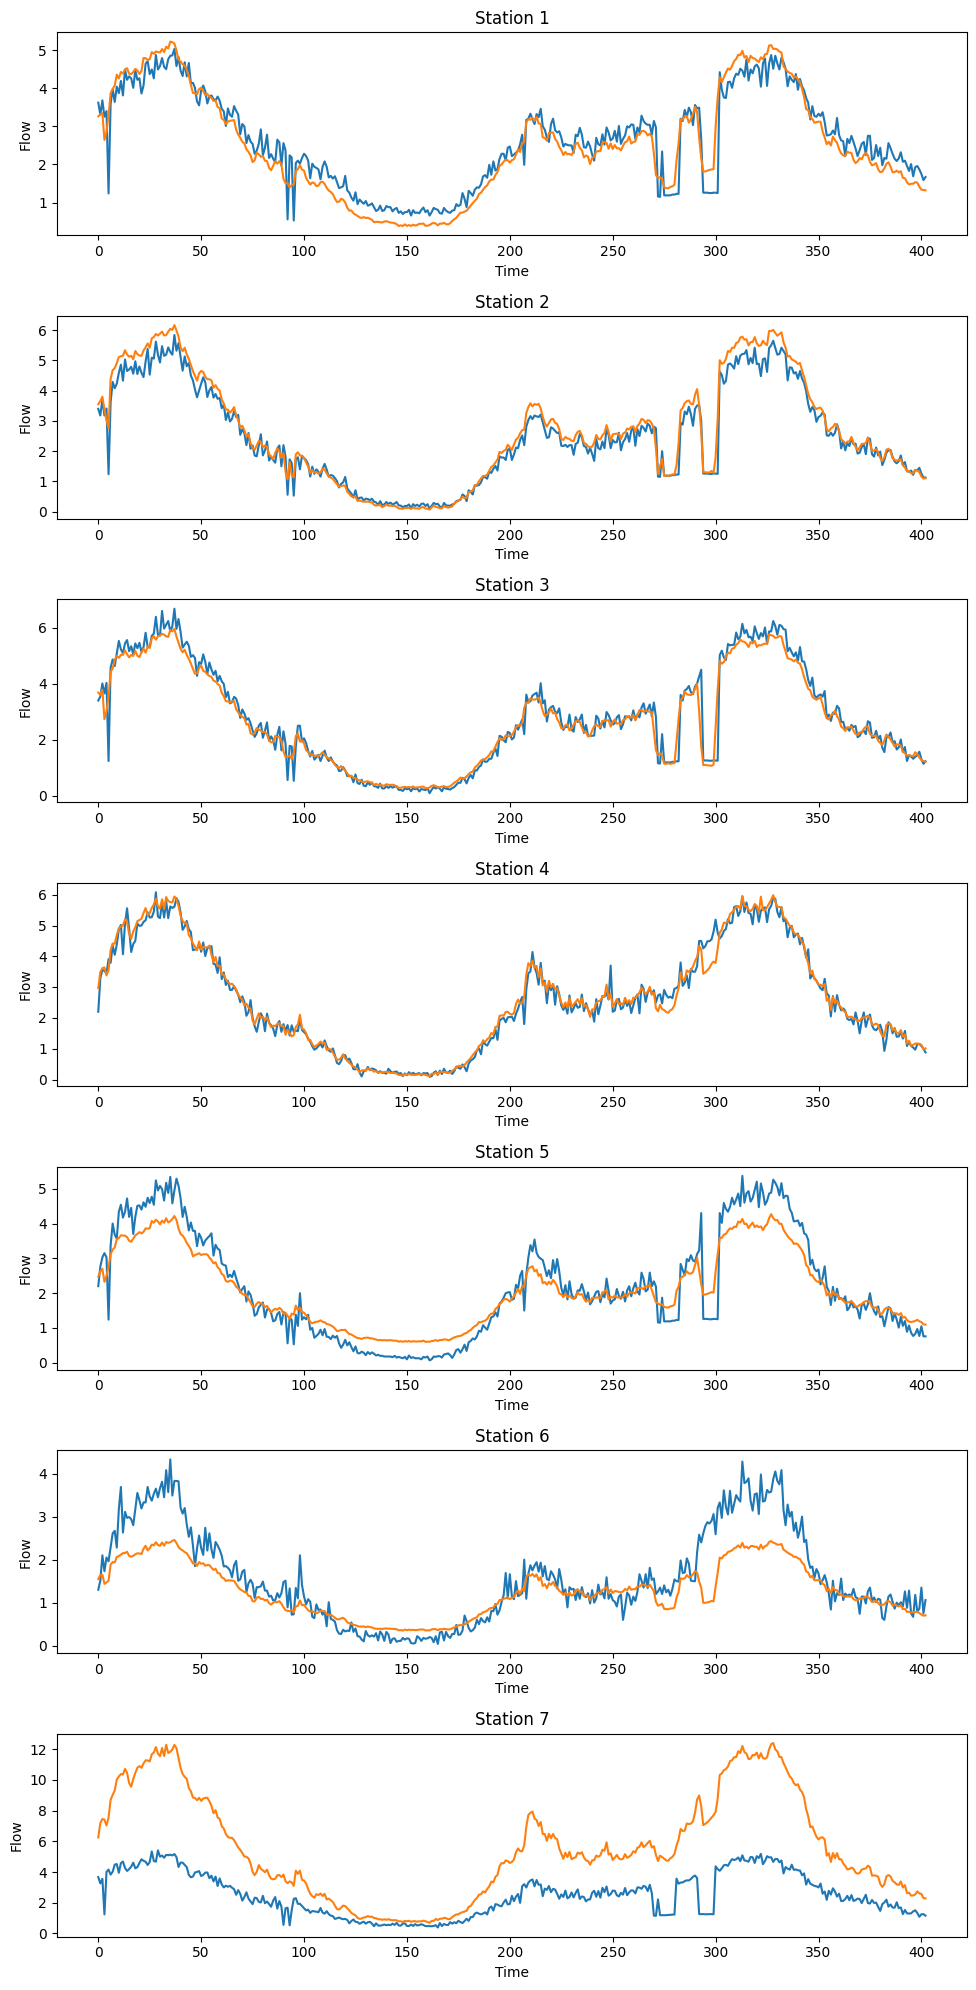

In [69]:
# Create a figure with 5 subplots (one for each column)
fig, axs = plt.subplots(nrows=X_ori.shape[1], ncols=1, figsize=(10, 20))

# Plot each column in a separate subplot
for i in range(X_ori.shape[1]):
    axs[i].plot(X_ori[:, i])
    axs[i].plot(z[:,i])

# Add titles and axis labels to the subplots
for i, ax in enumerate(axs):
    ax.set_title(f'Station {i+1}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Flow')

# Show the figure
plt.tight_layout()
plt.show()

In [71]:
dz_predict = results['dz_predict'].cpu().detach().numpy()
dz = results['dz'].cpu().detach().numpy()

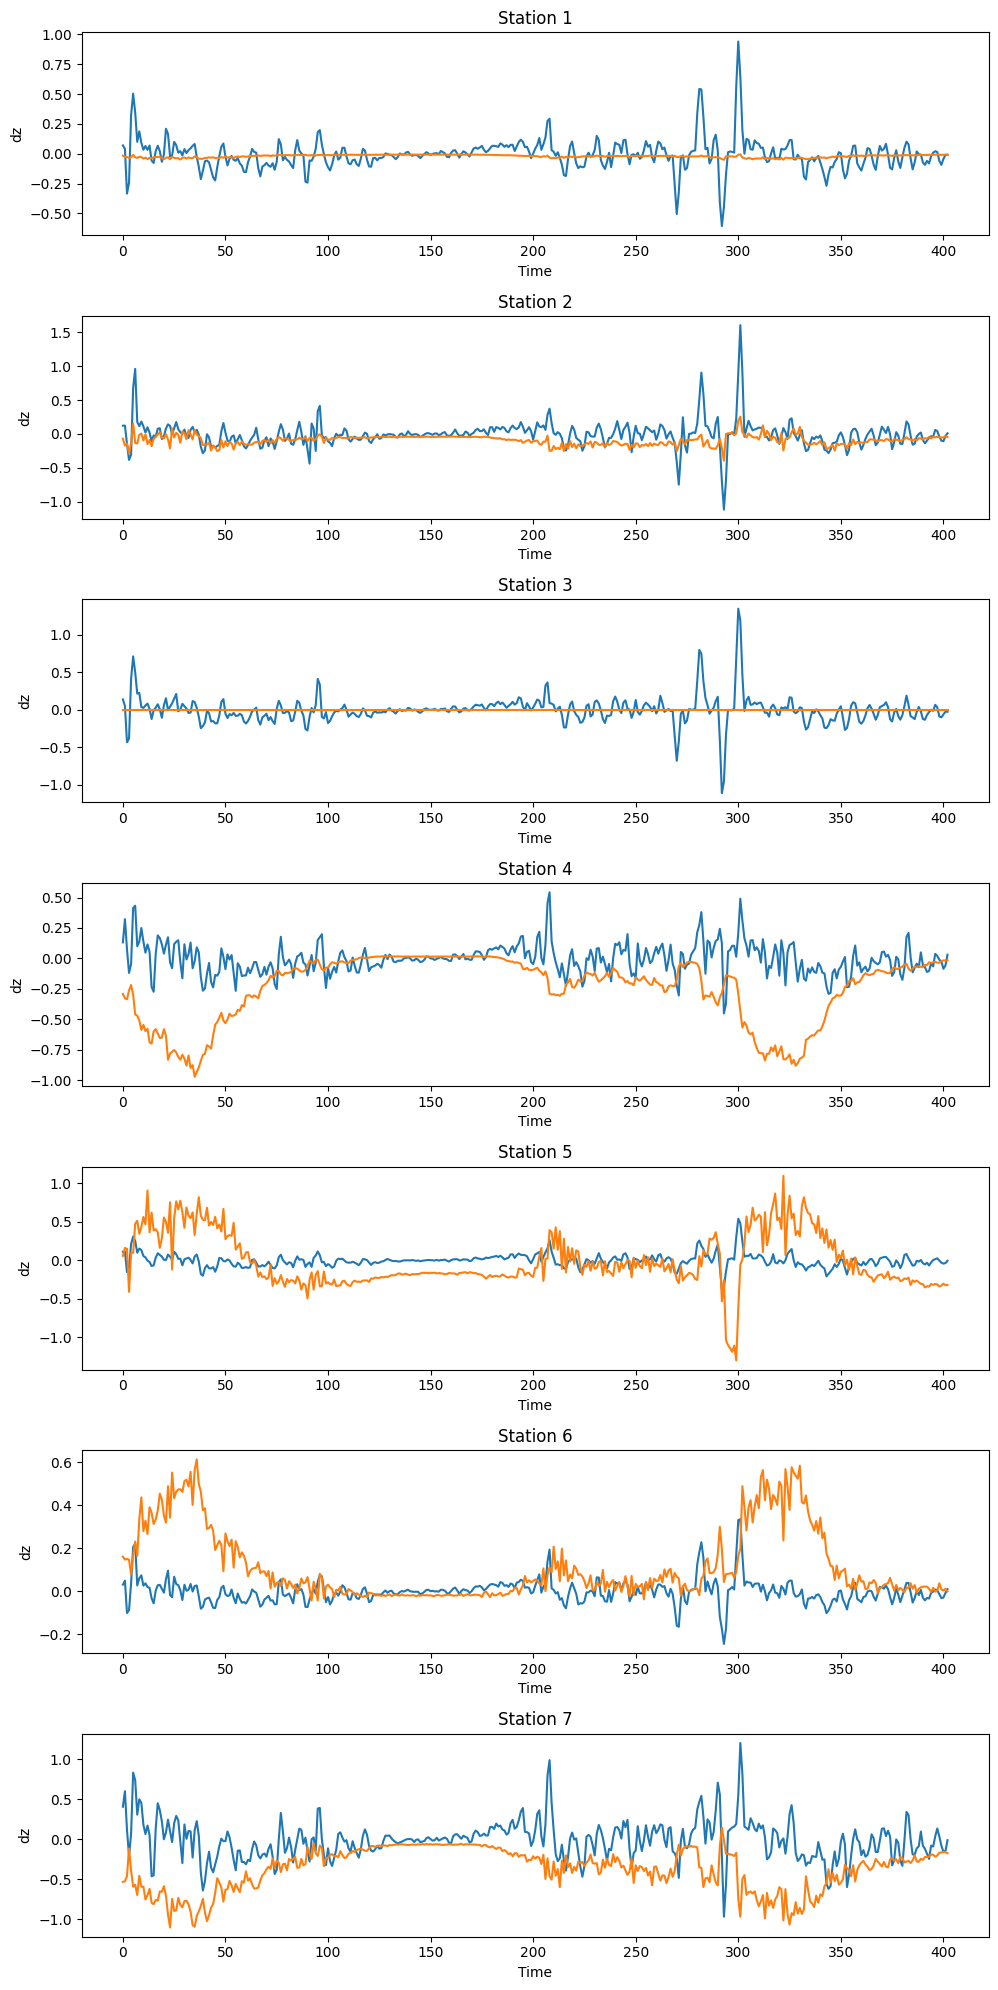

In [72]:
fig, axs = plt.subplots(nrows=X_ori.shape[1], ncols=1, figsize=(10, 20))

# Plot each column in a separate subplot
for i in range(X_ori.shape[1]):
    axs[i].plot(dz[:, i])
    axs[i].plot(dz_predict[:,i])

# Add titles and axis labels to the subplots
for i, ax in enumerate(axs):
    ax.set_title(f'Station {i+1}')
    ax.set_xlabel('Time')
    ax.set_ylabel('dz')

# Show the figure
plt.tight_layout()
plt.show()